In [ ]:
import chess
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 123456
np.random.seed(seed=seed)

# Реализуем board encoding


In [ ]:
def basic_piece_encoding(board):
    pieces = [
        "P",
        "N",
        "B",
        "R",
        "Q",
        "K",  # Белые
        "p",
        "n",
        "b",
        "r",
        "q",
        "k",
    ]  # Черные

    encoding = np.zeros((12, 8, 8), dtype=np.float32)

    for i, piece in enumerate(pieces):
        for square in range(64):
            if board.piece_at(square) and board.piece_at(square).symbol() == piece:
                row, col = square // 8, square % 8
                encoding[i, row, col] = 1.0

    return encoding

In [ ]:
def advanced_board_encoding(board):
    # Основные 12 плоскостей фигур
    encoding = basic_piece_encoding(board)

    # Плоскость 13: Чей ход
    turn_plane = (
        np.ones((1, 8, 8), dtype=np.float32)
        if board.turn
        else np.zeros((1, 8, 8), dtype=np.float32)
    )

    # Плоскости 14-17: Рокировки
    castling_rights = [
        board.has_kingside_castling_rights(chess.WHITE),
        board.has_queenside_castling_rights(chess.WHITE),
        board.has_kingside_castling_rights(chess.BLACK),
        board.has_queenside_castling_rights(chess.BLACK),
    ]
    castling_planes = np.zeros((4, 8, 8), dtype=np.float32)
    for i, has_right in enumerate(castling_rights):
        if has_right:
            castling_planes[i] = 1.0

    # Плоскость 18: Взятие на проходе
    en_passant_plane = np.zeros((1, 8, 8), dtype=np.float32)
    if board.ep_square is not None:
        row, col = board.ep_square // 8, board.ep_square % 8
        en_passant_plane[0, row, col] = 1.0

    # Плоскости 19-20: Счетчики (нормализованные)
    halfmove_plane = np.full((1, 8, 8), board.halfmove_clock / 50.0, dtype=np.float32)
    fullmove_plane = np.full((1, 8, 8), board.fullmove_number / 500.0, dtype=np.float32)

    # Объединяем все плоскости
    full_encoding = np.concatenate(
        [
            encoding,  # 12 плоскостей
            turn_plane,  # 1 плоскость
            castling_planes,  # 4 плоскости
            en_passant_plane,  # 1 плоскость
            halfmove_plane,  # 1 плоскость
            fullmove_plane,  # 1 плоскость
        ],
        axis=0,
    )  # Итого: 20 плоскостей

    return full_encoding

In [4]:
def fen_to_tensor(fen_string):
    board = chess.Board(fen_string)
    tensor = advanced_board_encoding(board)
    return tensor

In [5]:
data = pd.read_csv("fens_training_set.csv")

In [6]:
data.shape

(268550, 2)

# Проведём EDA


In [11]:
def validate_fen(fen):
    try:
        board = chess.Board(fen)
        return True
    except:
        return False

In [ ]:
data["fen_valid"] = data["fen"].apply(validate_fen)
print(f"Валидных FEN: {data['fen_valid'].sum()}/{len(data)}")

Валидных FEN: 268550/268550


In [13]:
def analyze_fen_structure(fen):
    board = chess.Board(fen)
    return {
        "piece_count": len(board.piece_map()),
        "white_to_move": board.turn,
        "castling_rights": board.castling_rights,
        "en_passant_possible": board.ep_square is not None,
        "halfmove_clock": board.halfmove_clock,
        "fullmove_number": board.fullmove_number,
    }

In [ ]:
fen_analysis = data[data["fen_valid"]]["fen"].apply(analyze_fen_structure)

In [15]:
fen_df = pd.DataFrame(fen_analysis.tolist())

In [16]:
print(f"Позиций где ход белых: {(fen_df['white_to_move'] == True).sum()}")
print(f"Позиций где ход черных: {(fen_df['white_to_move'] == False).sum()}")

Позиций где ход белых: 268550
Позиций где ход черных: 0


In [17]:
def analyze_move(move_uci, fen):
    """Детальный анализ хода"""
    try:
        board = chess.Board(fen)
        move = chess.Move.from_uci(move_uci)

        # Проверка легальности хода
        is_legal = move in board.legal_moves

        # Тип хода
        move_types = []
        if board.is_capture(move):
            move_types.append("capture")
        if board.is_castling(move):
            move_types.append("castling")
        if board.is_en_passant(move):
            move_types.append("en_passant")
        if move.promotion:
            move_types.append("promotion")
        if not move_types:
            move_types.append("quiet")

        # Фигура, которая ходит
        piece = board.piece_at(move.from_square)
        piece_type = piece.symbol().upper() if piece else None

        # Расстояние хода
        from_row, from_col = move.from_square // 8, move.from_square % 8
        to_row, to_col = move.to_square // 8, move.to_square % 8
        distance = np.sqrt((from_row - to_row) ** 2 + (from_col - to_col) ** 2)

        return {
            "is_legal": is_legal,
            "move_types": move_types,
            "piece_type": piece_type,
            "move_distance": distance,
            "is_check": board.gives_check(move),
        }
    except:
        return {
            "is_legal": False,
            "move_types": [],
            "piece_type": None,
            "move_distance": 0,
            "is_check": False,
        }

In [ ]:
move_analysis = data.apply(lambda row: analyze_move(row["move"], row["fen"]), axis=1)
move_df = pd.DataFrame(move_analysis.tolist())

In [19]:
print(f"Легальных ходов: {move_df['is_legal'].sum()}/{len(move_df)}")
print(f"Ходов, объявляющих шах: {move_df['is_check'].sum()}")

Легальных ходов: 268549/268550
Ходов, объявляющих шах: 22601


In [24]:
move_df[move_df["is_legal"] == False]

,is_legal,move_types,piece_type,move_distance,is_check
232329,False,[castling],K,2.0,True


In [ ]:
# Непонятно, почему посчитало нелегальным ходом
data.iloc[move_df[move_df["is_legal"] == False].index]

,fen,move,fen_valid
232329,1r2qk1r/ppb3pb/2p1P3/4p2p/4n3/1P1N3P/P1P3PB/1R...,f1h1,True


In [27]:
data.iloc[move_df[move_df["is_check"] == True].index]

,fen,move,fen_valid
4,rnbqkb1r/pp3ppp/5n2/3p4/2pP4/3B1N2/PPP2PPP/RNB...,f1e1,True
14,8/8/3r4/1pp1p2R/p2k4/P1p5/2B5/2K5 w - - 0 1,h5h4,True
16,r3k3/5p1p/1pp1n2r/p1p1PRp1/2PbN3/P6P/1PP3P1/R6...,e4d6,True
24,r1b2rk1/1p3n1R/p3p1p1/2q2pN1/8/2N4Q/PPP2PP1/2K...,h7h8,True
27,7r/R7/P3p3/1P1k4/2p5/4B2p/7b/2K5 w - - 0 1,a7d7,True
...,...,...,...
268509,rn1qkb1r/ppp1pppp/3p4/4Pb2/1nPP4/5N2/PP3PPP/RN...,d1a4,True
268514,r5k1/1p1n1ppn/1qr5/4p1N1/pBPb4/P4Q2/1P3PPP/1R1...,f3f7,True
268541,3rr3/1pR1b2p/p3QBpk/8/8/q4P2/5KPP/7R w - - 0 1,e6h3,True
268543,2rqnrk1/1p1b1pb1/p2p1Pp1/3N2Pp/2PpP3/1P1Q3P/P1...,d5e7,True


Text(0.5, 1.0, 'Распределение типов ходов (логарифмический масштаб)')

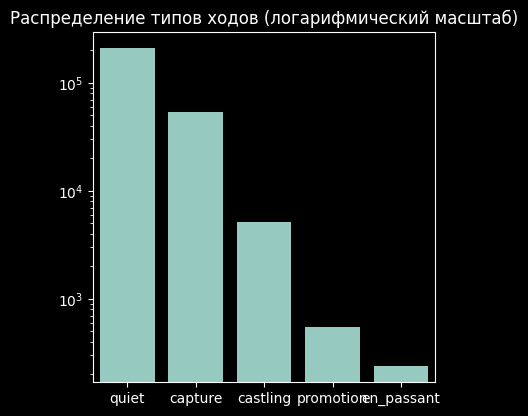

In [40]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
all_move_types = [
    item for sublist in move_df["move_types"].dropna() for item in sublist
]
move_type_counts = Counter(all_move_types)
sns.barplot(y=list(move_type_counts.values()), x=list(move_type_counts.keys()))
plt.yscale("log")
plt.title("Распределение типов ходов (логарифмический масштаб)")

Text(0.5, 1.0, 'Фигуры, совершающие ходы')

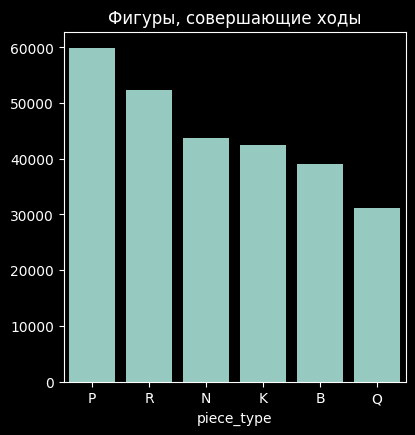

In [ ]:
plt.figure(figsize=(15, 10))
piece_counts = move_df["piece_type"].value_counts()
sns.barplot(y=piece_counts.values, x=piece_counts.index)
plt.title("Фигуры, совершающие ходы")

Text(0.5, 0, 'Количество фигур')

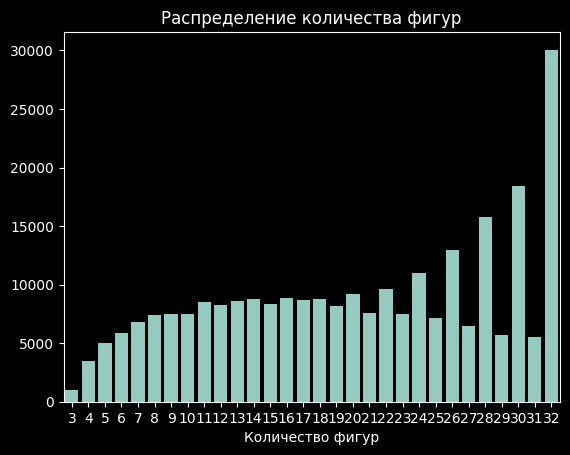

In [ ]:
# all_nums_figures_types = [
#     item for sublist in fen_df["piece_count"].dropna() for item in sublist
# ]
nums_figures_counts = Counter(fen_df["piece_count"])
sns.barplot(y=list(nums_figures_counts.values()), x=list(nums_figures_counts.keys()))
plt.title("Распределение количества фигур")
plt.xlabel("Количество фигур")

In [ ]:
def analyze_tactical_patterns(fen, move_uci):
    board = chess.Board(fen)
    move = chess.Move.from_uci(move_uci)

    patterns = []

    # Атака на короля
    if board.is_check():
        patterns.append("check")

    # Связка
    for square in chess.SQUARES:
        if board.is_pinned(board.turn, square):
            patterns.append("pin")
            break

    # Двойной удар
    board.push(move)
    attacked_squares = len(
        [sq for sq in chess.SQUARES if board.is_attacked_by(board.turn, sq)]
    )
    board.pop()

    # Взятие фигур
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        if captured_piece:
            patterns.append(f"capture_{captured_piece.symbol().upper()}")

    return patterns

In [ ]:
# Анализ тактических паттернов
data["tactical_patterns"] = data.apply(
    lambda row: analyze_tactical_patterns(row["fen"], row["move"]), axis=1
)

# Анализ частоты тактических паттернов
all_patterns = [item for sublist in data["tactical_patterns"] for item in sublist]
pattern_counts = Counter(all_patterns)

print("Топ тактических паттернов:")
for pattern, count in pattern_counts.most_common(10):
    print(f"  {pattern}: {count}")

Топ тактических паттернов:
  pin: 35255
  capture_P: 25655
  check: 19590
  capture_N: 9021
  capture_B: 8570
  capture_R: 6390
  capture_Q: 4057


# Разработка модели
